## a sub-diffusion code

Producing a self similar analytic solution as $u(x,t)=B(x,t)$ where $B(x,t)$ is a Baranblatt profile, and a separable solution $u(x,t)=\frac{-x^2}{6t}$

In [35]:
function barenblatt(x::Float64, t::Float64)
    A=0.16666666666666
    if A >= ((x^2)/(6*(t^0.666666)))
        return (t^(-0.333333333))*(A-((x^2)/(6*(t^0.666666))))
    else
        return 0
    end
end;

function B(x::Array{Float64,1},t::Float64)
    return map(u->barenblatt(u,t),x)
end;

Separable(x,t)=-x^2/(6*t)
SSol(x,t)=map(a->Separable(a,t),x)

SSol (generic function with 1 method)

In [36]:
X=collect(-499:500);
X=map(x->0.01*x,X);


In [37]:
import Pkg; Pkg.add("Plots");
using Plots;

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %Fetching: [======>                                  ]  13.5 %31.7 %>                     ]  46.0 %Fetching: [===========================>             ]  66.9 %       ]  81.1 %    ]  89.6 % Resolving package versions...
 Installed ImageMetadata ── v0.6.1
 Installed Tables ───────── v0.1.15
 Installed Compat ───────── v1.5.1
 Installed MbedTLS ──────── v0.6.7
 Installed IdentityRanges ─ v0.3.0
 Installed OffsetArrays ─── v0.10.0
 Installed ImageCore ────── v0.7.4
 Installed TikzPictures ─── v3.0.4
 Installed Conda ────────── v1.2.0
 Installed Images ───────── v0.17.2
 Installed WeakRefStrings ─ v0.5.5
 Installed Interpolations ─ v0.11.2
 Installed ImageFiltering ─ v0.5.3
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [34da2185] 

In [38]:

gr()


Plots.GRBackend()

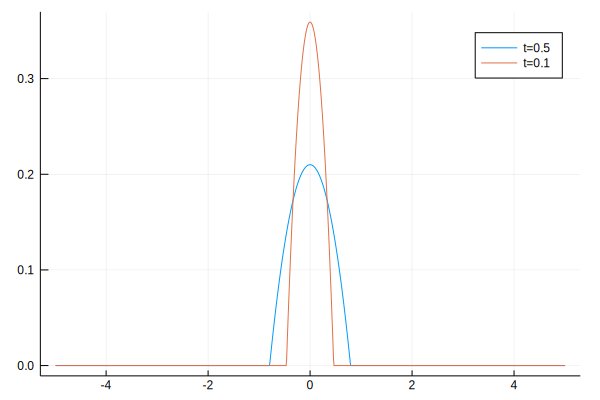

In [39]:
BB=B(X,0.1)
plot(X,B(X,0.5),label="t=0.5")
plot!(X,B(X,0.1),label="t=0.1")

#### Globals

In [40]:
h=0.1;
NGH=1;

#### Boundary conditions

In [41]:
function Constant(u::Array{Float64,1},x::Array{Float64,1},t::Float64,K::Float64)
    L=length(u)
    for i=1:NGH
        u[i]=K
        u[L-i]=K
    end
end

function Time_dependant_diffusion(u::Array{Float64,1},x::Array{Float64,1},t::Float64)
        #u[i]=(x[i]^2)/(6.0*t^2)
    #println(-(x[end]^2)/(6.0*t))
    return (-(x[1]^2)/(6.0*t)),(-(x[end]^2)/(6.0*t))
end

#Bound(u,x,t)=Constant(u,x,t,0.0)
Bound(u,x,t)=Time_dependant_diffusion(u,x,t)

Bound (generic function with 1 method)

#### Spatial discretistion and functions -Central Finite Differences-

In [42]:
∂ₓ(u::Array{Float64,1},i::Int64) = (u[i+1]-u[i-1])/(2.0*h)
∂ₓₓ(u::Array{Float64,1},i::Int64) = (u[i+1]-2.0*u[i]+u[i-1])/(h^2)

D(A::Float64) = A
F(u::Array{Float64,1},i::Int64) = D(u[i])*∂ₓₓ(u,i) + ∂ₓ(u,i)^2

F (generic function with 1 method)

#### Time integration -RKL2-

In [43]:
function b(j)
    J=convert(Float64,j)
    if j < 3
        B=0.33333333333333333
    else
        B=(J^2 + J -2)/(2J*(J+1))
    end
    return B
end

function w(s)
    S=convert(Float64,s)
    W=4/(S^2 + S -2)
    return W
end

function μ(j)
    J=convert(Float64,j)
    MU=((2J-1)/J)*(b(j)/b(j-1))
    return MU
end

function ν(j)
    J=convert(Float64,j)
    NU=-((J-1)/J)*(b(j)/b(j-2))
    return NU
end

μ_2(j,s)=μ(j)*w(s)

function γ_2(j,s)
    GAM=-μ_2(j,s)*(1-b(j-1))
    return GAM
end

function current_time(j::Int,s::Int32)
    J=convert(Float64,j)
    S=convert(Float64,s)
    return (J^2+J-2)/(S^2+S-2)
end

function calc_t_parab(D::Function,D_array::Array{Float64,1},F::Array{Float64,1})
    D_array=map(x->D(x),F)
    t=maximum(abs.(D_array))
    t=0.5*abs((h^2)/t)
    return t
end

function Dot(F::Function,u::Array{Float64,1},result::Array{Float64,1})
    for i=(1+NGH):(length(u)-NGH)
        result[i]=F(u,i)
    end
    return result
end

function step_calc(τ::Float64,t_parab::Float64)
    delta=9+16*(τ/t_parab)
    #println(delta)
    return convert(Int32,ceil(0.5*sqrt(delta)-0.5))
end

function RKL_step(u::Array{Float64,1},x::Array{Float64,1},t_now::Float64,
                D_array::Array{Float64,1},F::Function,D::Function,
                τ::Float64,temp::Array{Float64,2})
    s=step_calc(τ,calc_t_parab(D,D_array,u))
    #println("steps=",s)
    Y0=u
    temp[1,:]=Y0
    temp[2,:]=Y0+μ_2(1,s)*τ*Dot(F,Y0,temp[4,:])
    Bound(temp[1,:],x,t_now)
    Bound(temp[2,:],x,t_now)
    for j=2:s
        i=((j)%3)+1
        temp[i,:]=μ(j)*temp[((j-1)%3)+1,:] +
                          ν(j)*temp[((j-2)%3)+1,:] +
                          (1-μ(j)-ν(j))*Y0 +
                          μ_2(j,s)*τ*Dot(F,temp[((j-1)%3)+1,:],temp[5,:]) +
                          γ_2(j,s)*τ*Dot(F,Y0,temp[4,:])
        temp[i,1],temp[i,end]=Bound(temp[i,:],x,t_now+τ*current_time(j,s))
    end
    return temp[((s)%3)+1,:]
end
    
    
#function RK4_step(u::Array{Float64,1},D_array::Array{Float64,1},F::Function,D::Function,τ::Float64,temp::Array{Float64,2})
    
function nSteps(n::Int64,init::Array{Float64,1},grid::Array{Float64,1},
                t_init::Float64,DARRAY::Array{Float64,1},F::Function,
                Df::Function,τ::Float64,TempMatrix::Array{Float64,2})
    u=deepcopy(init)
    time=t_init
    for i=1:n
        u=RKL_step(u,grid,time,DARRAY,F,Df,τ,TempMatrix)
        time+=τ
        #println(time,"\n")
        #Sol=hcat(Sol,u)
    end
    return u
end 
    

nSteps (generic function with 1 method)

#### Error analysis

In [44]:
∑=sum;
L1(Theoretical::Array{Float64,1}, Numerical::Array{Float64,1})=∑(abs.(Theoretical-Numerical))/convert(Float64,length(Theoretical))
Pnorm(N::Int,Theoretical::Array{Float64,1}, Numerical::Array{Float64,1})=∑(abs.(Theoretical.^N -Numerical.^N))/convert(Float64,length(Theoretical))

Pnorm (generic function with 1 method)

#### Program proper

In [45]:
τ=0.01;
t₀=-10.0;

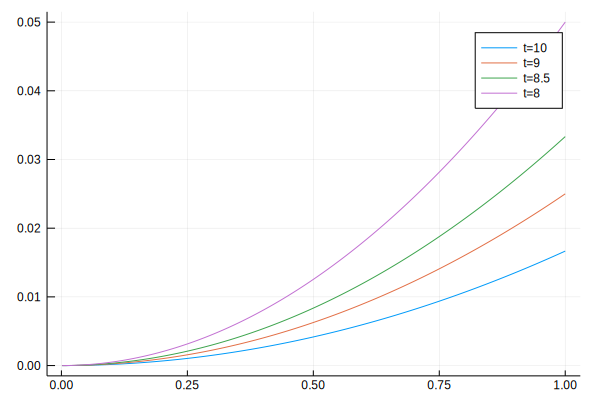

In [56]:
h=1.0/convert(Float64,700);
mesh=map(x->h*x,collect(1:700));
TempMatrix=zeros(5,700);
DARRAY=zeros(700);
u=SSol(mesh,t₀);
umin=deepcopy(u);
u=nSteps(100,umin,mesh,t₀,DARRAY,F,D,τ,TempMatrix);
u1=nSteps(150,umin,mesh,t₀,DARRAY,F,D,τ,TempMatrix);
u2=nSteps(200,umin,mesh,t₀,DARRAY,F,D,τ,TempMatrix);
plot(mesh,umin,label="t=10")
plot!(mesh,u,label="t=9")
plot!(mesh,u1,label="t=8.5")
plot!(mesh,u2,label="t=8")

In [46]:
Norm=[]

for N ∈ 10*collect(70:150)
    h=10.0/convert(Float64,N);
    mesh=map(x->h*x,collect(1:N));
    TempMatrix=zeros(5,N);
    DARRAY=zeros(N);
    u=SSol(mesh,t₀);
    umin=deepcopy(u);
    u=nSteps(100,umin,mesh,t₀,DARRAY,F,D,τ,TempMatrix);
    Norm=vcat(Norm,Pnorm(2,SSol(mesh,t₀+100.0*τ),u));
end


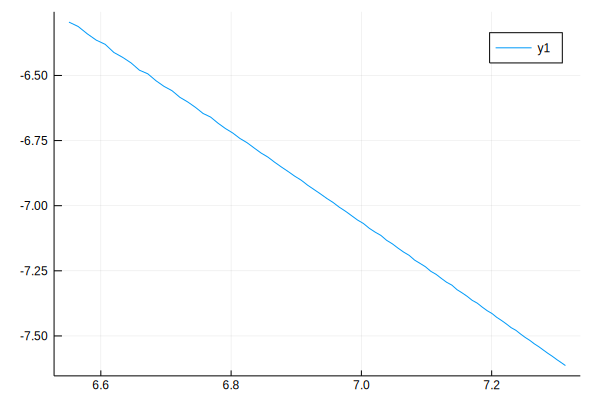

In [47]:
plot(log.(10*collect(70:150)),log.(Norm))

In [132]:
(log(Norm[1])-log(Norm[end]))/(log(700.0)-log(1500))

-1.7307331905166492

In [48]:
h=10.0/convert(Float64,700);
mesh=map(x->h*x,collect(1:700));
t₀=-10.0;
TempMatrix=zeros(5,700);
DARRAY=zeros(700);

In [49]:
NormT=[]

for N ∈ collect(70:150)
    τ=5.0/convert(Float64,N)
    u=SSol(mesh,t₀);
    umin=deepcopy(u);
    u=nSteps(N,umin,mesh,t₀,DARRAY,F,D,τ,TempMatrix);
    NormT=vcat(NormT,L1(SSol(mesh,t₀+5.0),u));
    println(N)
end


70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


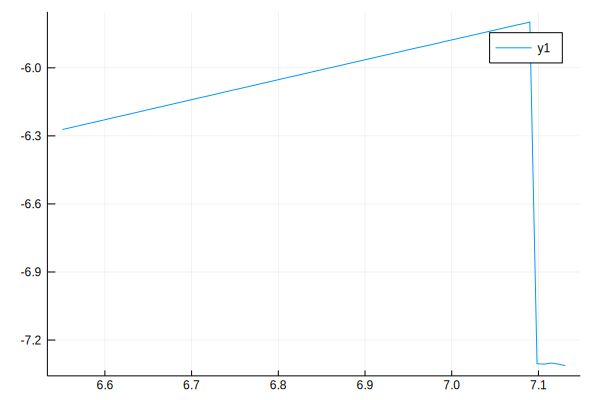

In [137]:
plot(log.(10*collect(70:125)),log.(NormT))

In [138]:
(log(NormT[1])-log(NormT[end-5]))/(log(700.0)-log(1200))

0.8782397698581145

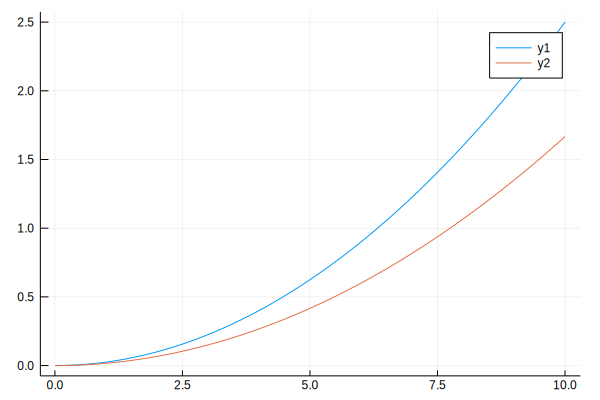

In [52]:
plot(mesh,SSol(mesh,t₀+100.0*τ))
plot!(mesh,SSol(mesh,t₀))